Processing file: https://raw.githubusercontent.com/humdrum-tools/bach-wtc-fugues/refs/heads/master/kern/wtc1f01.krn



,Measure,Local Onset,Global Onset,Duration,Pitch,MIDI
0,1,0.50,0.50,0.500,C4,60
1,1,1.00,1.00,0.500,D4,62
2,1,1.50,1.50,0.500,E4,64
3,1,2.00,2.00,0.750,F4,65
4,1,2.75,2.75,0.125,G4,67
...,...,...,...,...,...,...
787,27,1.50,105.50,0.500,D5,74
788,27,1.75,105.75,0.250,B5,83
789,27,2.00,106.00,2.000,C6,84
790,27,2.00,106.00,2.000,G5,79


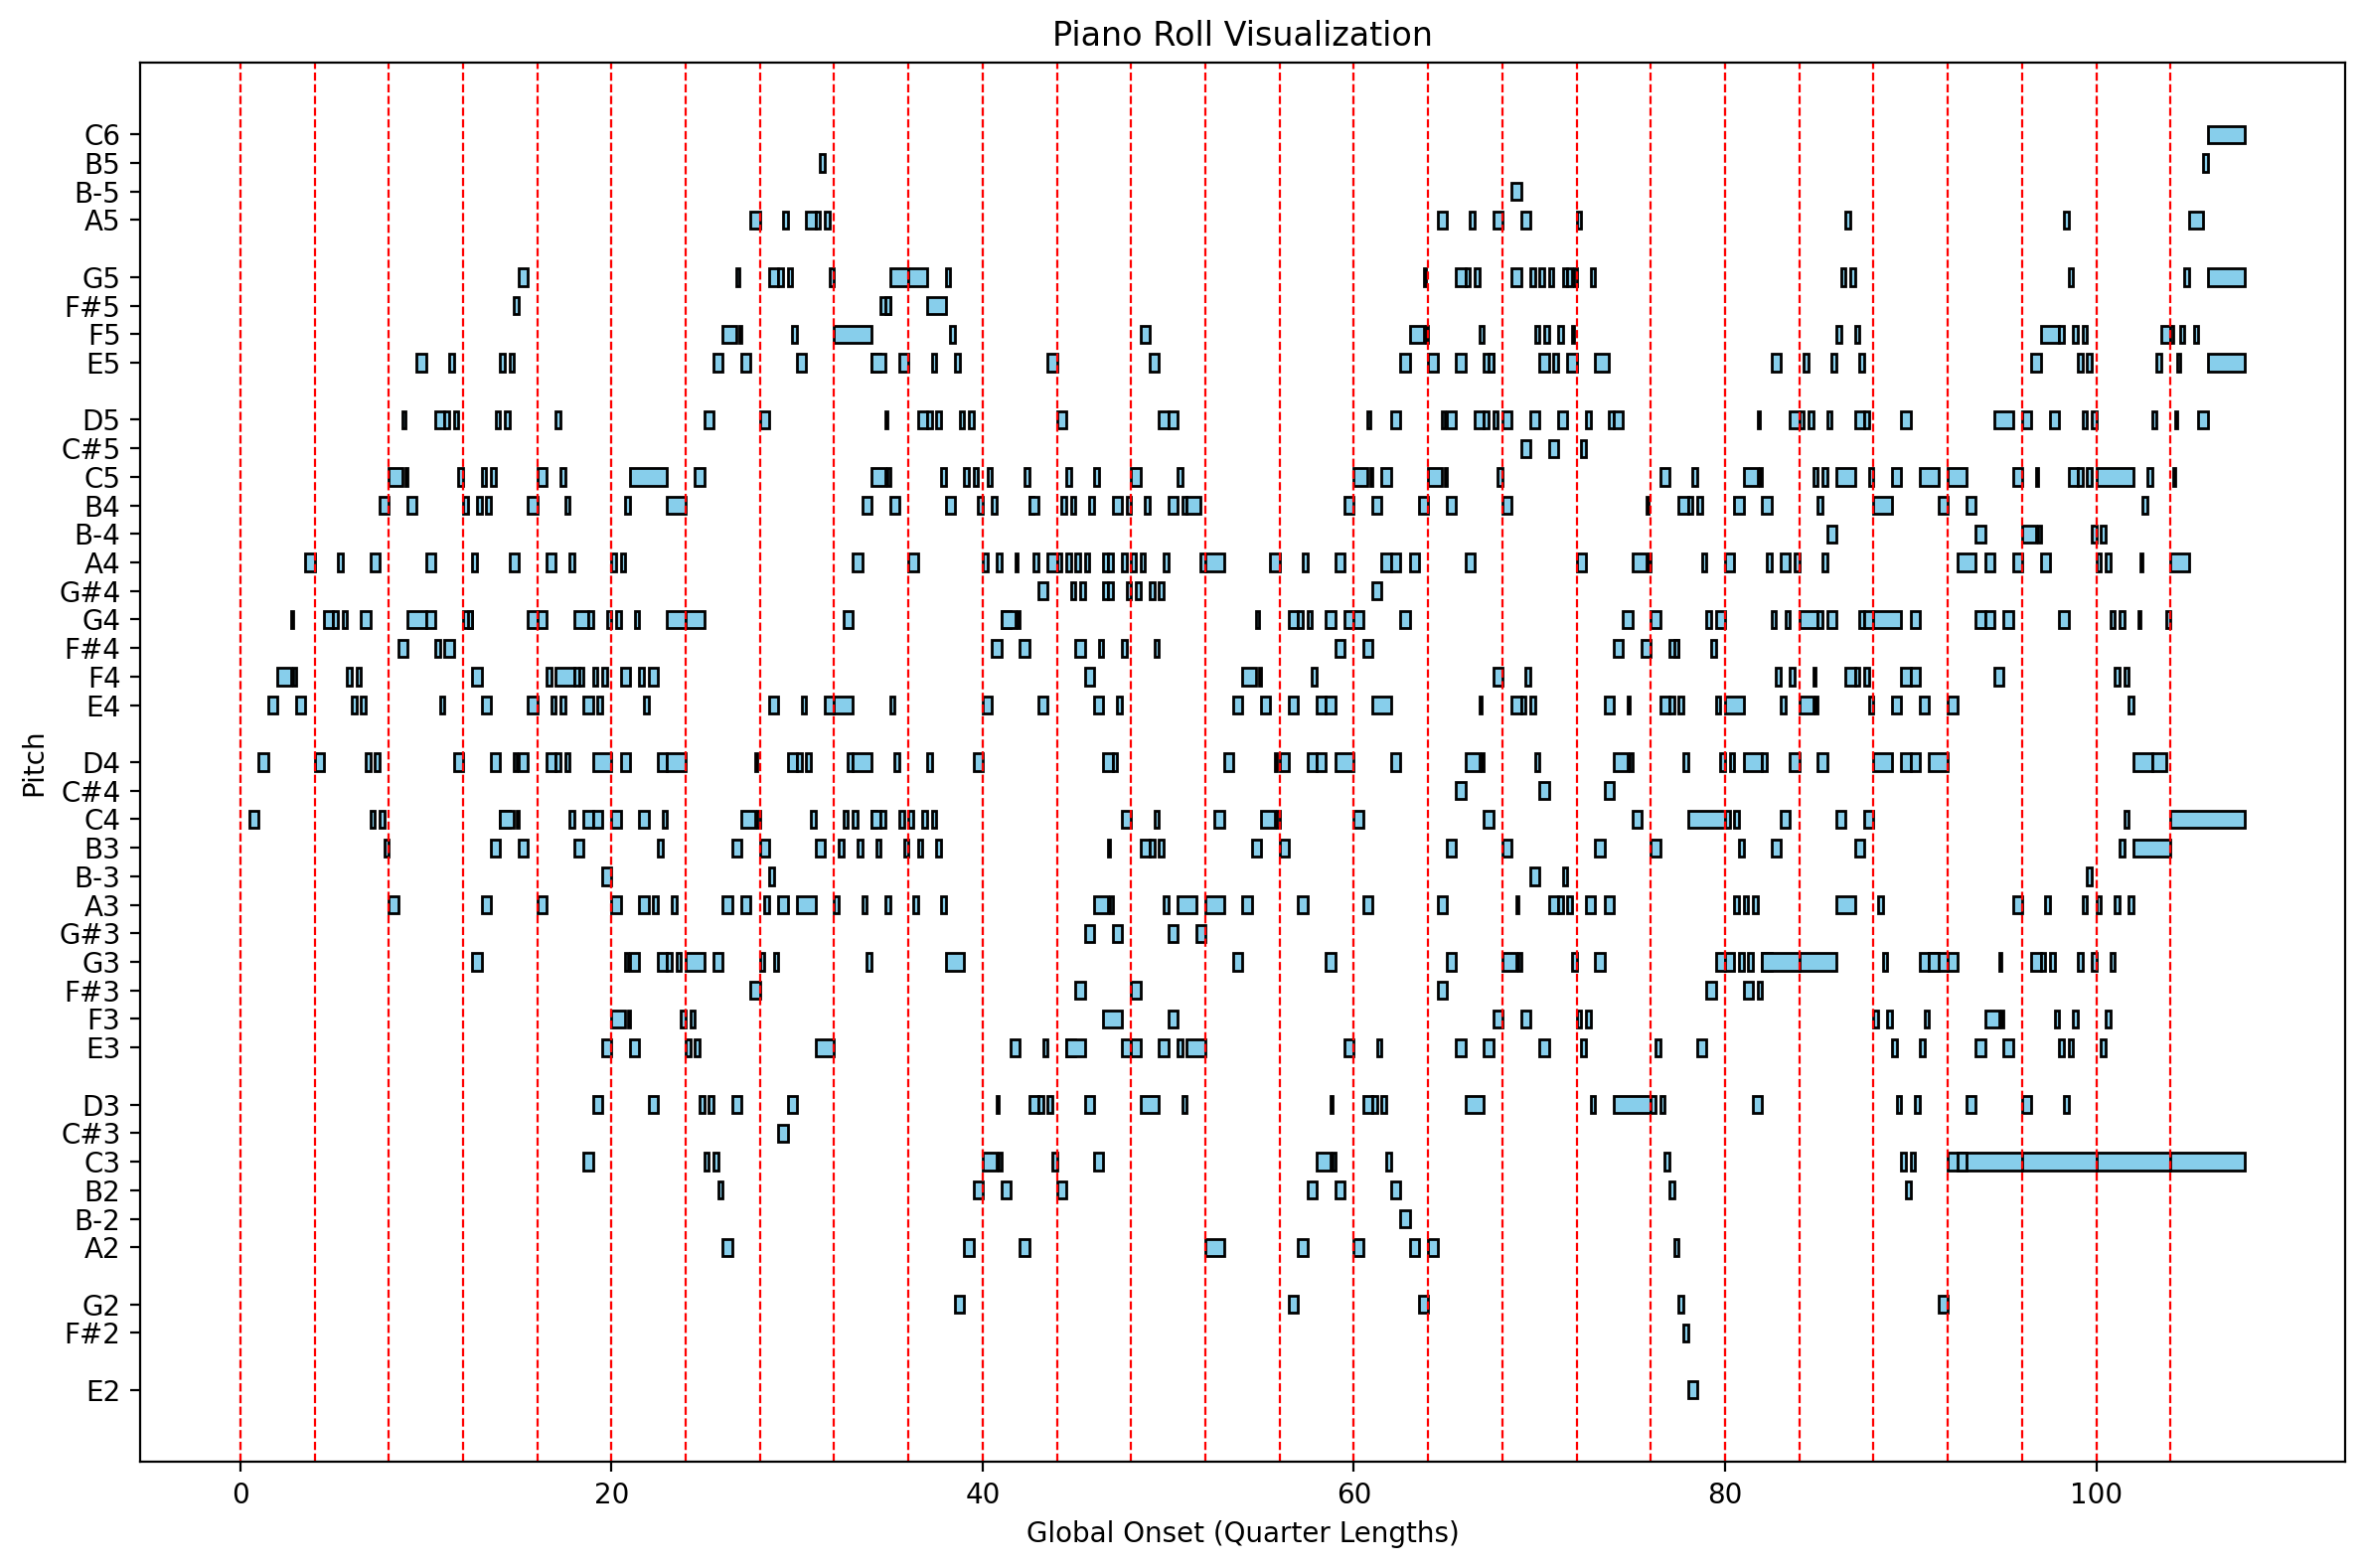

In [1]:
# Import necessary libraries
import os
import tempfile
import requests
import pandas as pd
import matplotlib.pyplot as plt
from music21 import converter, note, chord, pitch as pitch_module
from IPython.display import display

# Function to get the local file path from a URL or verify a local path
def get_file_path(file_source):
    """
    Determines if file_source is a URL or a local path.
    Downloads the file if it's a URL and returns the local path.
    Verifies and returns the path if it's a local file.

    Parameters
    ----------
    file_source : str
        URL or local file path.

    Returns
    -------
    str
        Local file path.

    Raises
    ------
    ValueError
        If there's an issue downloading the file.
    FileNotFoundError
        If the local file does not exist.
    """
    if file_source.startswith(('http://', 'https://')):
        try:
            response = requests.get(file_source, stream=True)
            response.raise_for_status()
            _, file_extension = os.path.splitext(file_source)
            temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=file_extension)
            with temp_file as tf:
                tf.write(response.content)
            return temp_file.name
        except requests.RequestException as e:
            raise ValueError(f"Error downloading the file: {e}")
    else:
        if os.path.exists(file_source):
            return file_source
        else:
            raise FileNotFoundError(f"Local file does not exist: {file_source}")

# Function to extract voice data from the score
def extract_voice_data(score):
    """
    Extracts measure number, global onset, local onset, duration, and pitch from a music21 score.

    Parameters
    ----------
    score : music21.stream.Score
        The music21 score object.

    Returns
    -------
    list of tuples
        Each tuple contains (Measure, Local Onset, Global Onset, Duration, Pitch).
    """
    voice_data = []
    notes_and_chords = score.flatten().notesAndRests.stream()

    for element in notes_and_chords:
        if isinstance(element, (note.Note, chord.Chord)):
            # Get the measure context
            measure = element.getContextByClass('Measure')
            if measure is not None:
                measure_num = measure.number
                measure_offset = measure.offset
            else:
                # If measure context is not found, default to 0
                measure_num = 0
                measure_offset = 0.0

            global_onset = element.offset
            local_onset = global_onset - measure_offset
            duration = element.duration.quarterLength

            # Handle notes and chords
            if isinstance(element, note.Note):
                pitches = [str(element.pitch)]
            else:
                pitches = [str(p) for p in element.pitches]

            # Append data for each pitch
            voice_data.extend([
                (measure_num, local_onset, global_onset, duration, pitch)
                for pitch in pitches
            ])

    return voice_data

# Function to create a piano roll plot with measure lines
def create_piano_roll(df, measure_offsets=None):
    """
    Generates a piano roll visualization from the DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'Measure', 'Local Onset', 'Global Onset', 'Duration', 'Pitch', and 'MIDI'.
    measure_offsets : list of floats, optional
        List of global onset times where measures start. If provided, vertical lines will be drawn at these positions.
    """
    # Ensure unique MIDI to pitch mapping
    midi_to_pitch = df.drop_duplicates('MIDI').set_index('MIDI')['Pitch'].to_dict()

    plt.figure(figsize=(12, 8))
    for _, row in df.iterrows():
        plt.barh(
            row['MIDI'],
            width=row['Duration'],
            left=row['Global Onset'],
            height=0.6,
            color='skyblue',
            edgecolor='black'
        )

    plt.yticks(list(midi_to_pitch.keys()), list(midi_to_pitch.values()))
    plt.xlabel('Global Onset (Quarter Lengths)')
    plt.ylabel('Pitch')
    plt.title('Piano Roll Visualization')

    # Draw measure lines if measure offsets are provided
    if measure_offsets is not None:
        for m_offset in measure_offsets:
            plt.axvline(x=m_offset, color='red', linestyle='--', linewidth=0.8)

    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Function to filter and adjust durations in the DataFrame
def filter_and_adjust_durations(df, filter_zero_duration=True, adjust_fractional_duration=True):
    """
    Filters out zero-duration notes and adjusts fractional durations.

    Parameters
    ----------
    df : pandas.DataFrame
        Original DataFrame.
    filter_zero_duration : bool, optional
        If True, removes rows with Duration <= 0. Default is True.
    adjust_fractional_duration : bool, optional
        If True, rounds 'Duration', 'Local Onset', and 'Global Onset' to 3 decimal places. Default is True.

    Returns
    -------
    pandas.DataFrame
        Processed DataFrame.
    """
    df_processed = df.copy()

    if filter_zero_duration:
        df_processed = df_processed[df_processed['Duration'] > 0]

    if adjust_fractional_duration:
        df_processed['Duration'] = df_processed['Duration'].round(3)
        df_processed['Local Onset'] = df_processed['Local Onset'].round(3)
        df_processed['Global Onset'] = df_processed['Global Onset'].round(3)

    return df_processed

# Configuration flags
FILTER_ZERO_DURATION = True        # Set to False to include zero-duration notes
ADJUST_FRACTIONAL_DURATION = True  # Set to False to keep original durations

# List of file sources (URLs or local paths)
file_sources = [
    #'https://analyse.hfm-weimar.de/database/02/PrJode_Jos0302_COM_1-5_MissaDapac_002_00006.xml',
    'https://raw.githubusercontent.com/humdrum-tools/bach-wtc-fugues/refs/heads/master/kern/wtc1f01.krn',
    #'https://raw.githubusercontent.com/WolfgangDrescher/lassus-geistliche-psalmen/master/kern/08-domine-dominus-noster.krn'
    #'https://raw.githubusercontent.com/music-encoding/sample-encodings/main/MEI_5.0/Music/Complete_examples/Bach-JS_Ein_feste_Burg.mei'
    # Add more file sources as needed
]

# Processing loop
for file_source in file_sources:
    try:
        print(f"Processing file: {file_source}\n")

        # Get the local file path
        file_path = get_file_path(file_source)

        # Parse the music file
        score = converter.parse(file_path)

        # Extract voice data
        voice_data = extract_voice_data(score)

        # Create DataFrame with specified column order
        df = pd.DataFrame(voice_data, columns=['Measure', 'Local Onset', 'Global Onset', 'Duration', 'Pitch'])
        df = df[['Measure', 'Local Onset', 'Global Onset', 'Duration', 'Pitch']]

        # Convert Pitch to MIDI with error handling
        try:
            df['MIDI'] = df['Pitch'].apply(lambda x: pitch_module.Pitch(x).midi)
        except Exception as e:
            print(f"Error converting pitch to MIDI: {e}")
            continue

        # Process the DataFrame
        df_processed = filter_and_adjust_durations(
            df,
            filter_zero_duration=FILTER_ZERO_DURATION,
            adjust_fractional_duration=ADJUST_FRACTIONAL_DURATION
        )

        # Display the processed DataFrame
        display(df_processed)

        # Get measure offsets for drawing measure lines
        # Assuming all parts have the same measure structure
        measures = score.parts[0].getElementsByClass('Measure')
        measure_offsets = [measure.offset for measure in measures]

        # Create the piano roll visualization with measure lines
        create_piano_roll(df_processed, measure_offsets=measure_offsets)

        # Optionally, delete the temporary file if it was downloaded
        if file_source.startswith(('http://', 'https://')):
            os.remove(file_path)

    except Exception as e:
        print(f"An error occurred while processing {file_source}: {e}\n")


Using automatic resolution based on smallest duration: 0.125
Total duration: 110.0, Number of columns: 880


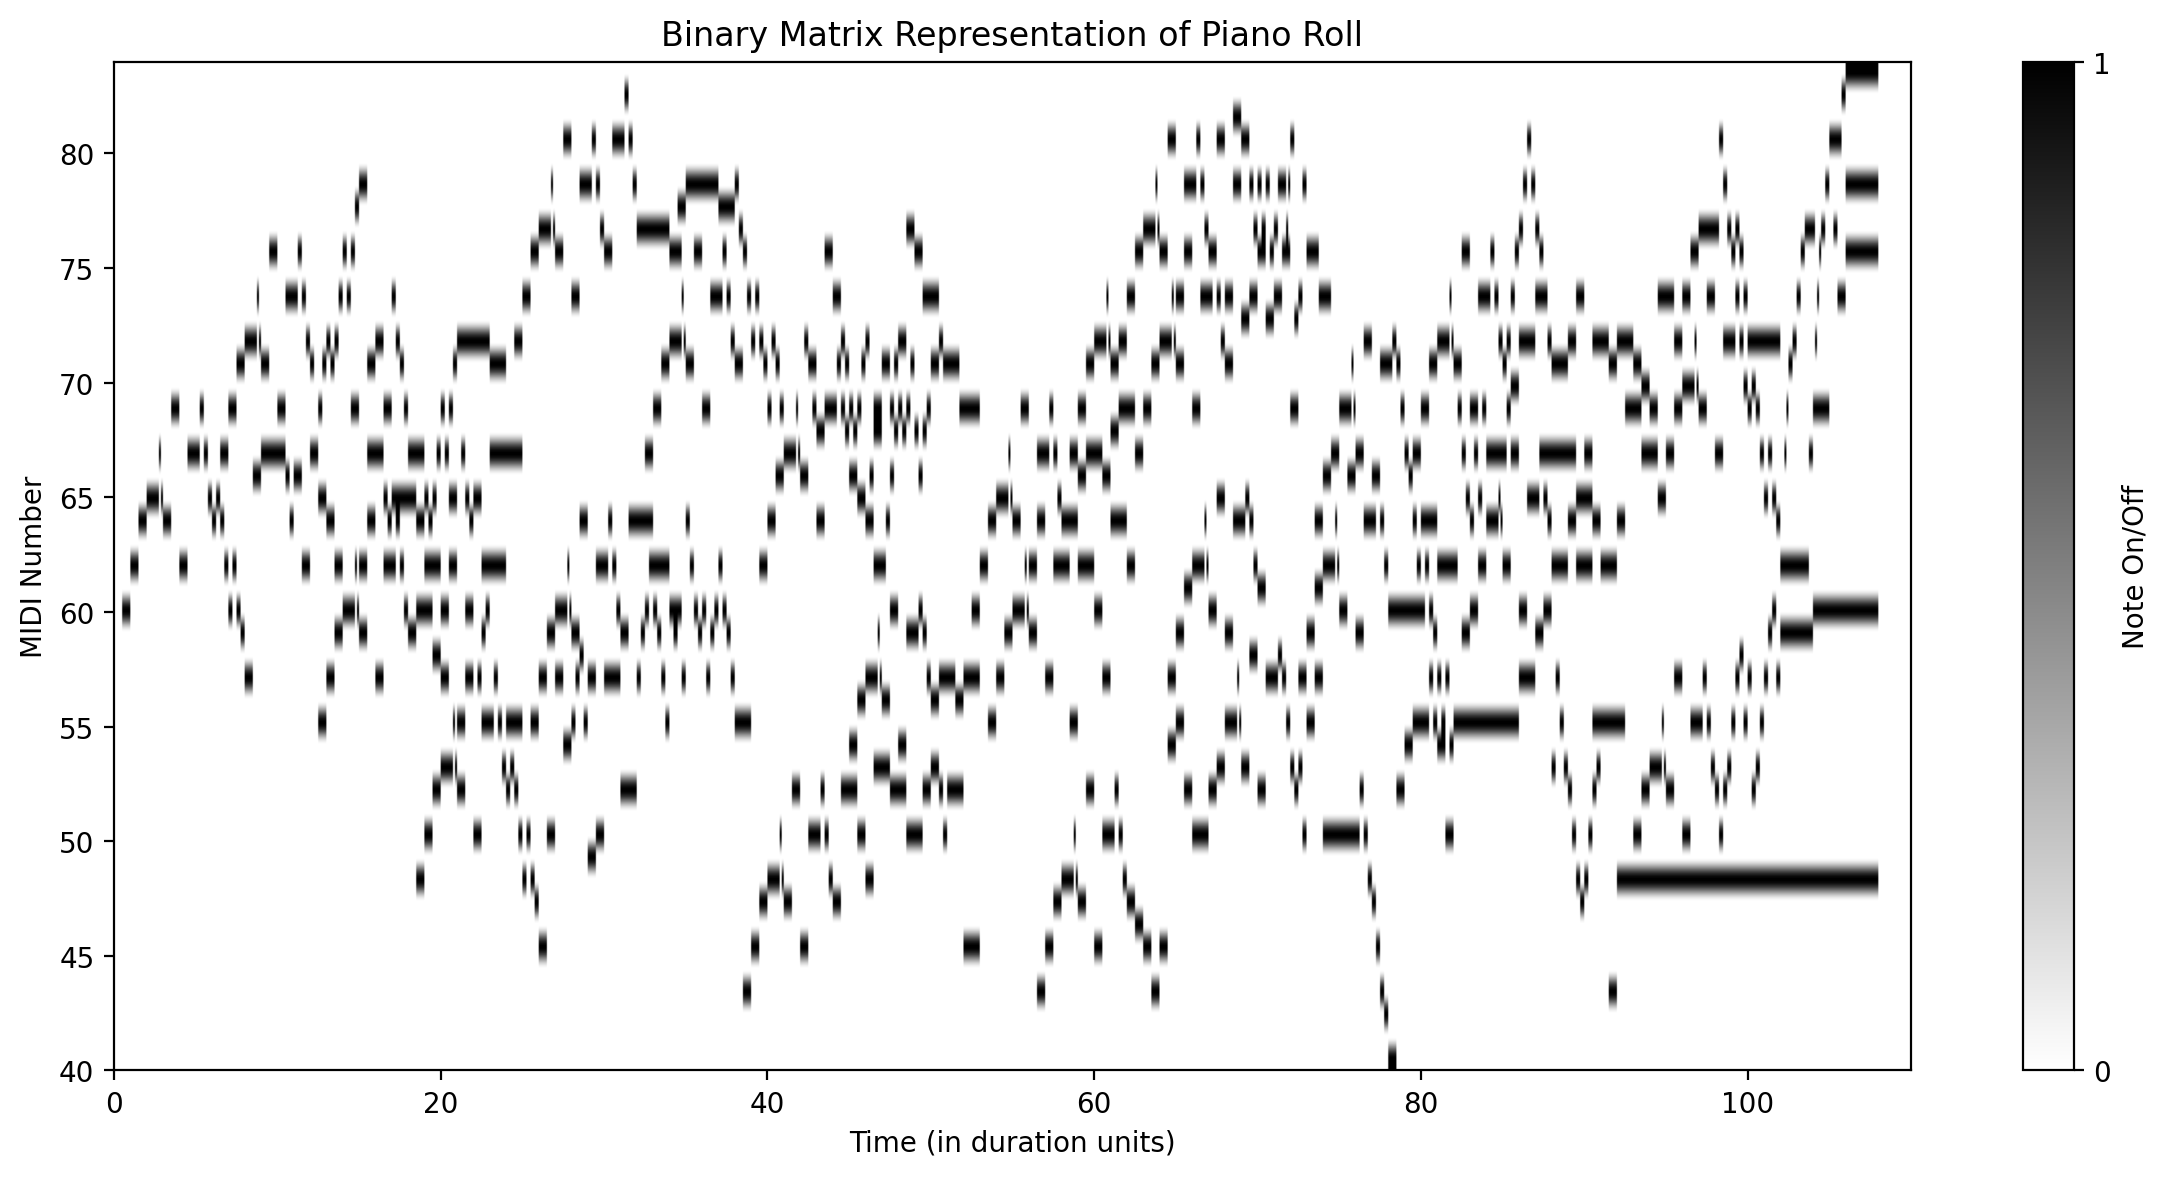

Dimensions of binary matrix: (45, 880)
Binary Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_binary_matrix(df_processed, resolution_method='auto', manual_resolution=None):
    """
    Converts a dataframe with parsed symbolic music information into a binary matrix.

    Parameters:
    - df_processed (pd.DataFrame): DataFrame containing music information with at least 'MIDI',
                                    'Duration', and 'Global Onset' columns.
    - resolution_method (str): Method to determine time resolution.
                               Options: 'auto', 'manual', 'standard'
    - manual_resolution (float): The smallest duration unit to use if resolution_method is 'manual'.

    Returns:
    - binary_matrix (np.ndarray): Binary matrix representation of the piano roll.
    - lowest_midi (int): Lowest MIDI number in the data.
    - highest_midi (int): Highest MIDI number in the data.
    - num_cols (int): Number of time columns in the binary matrix.
    - resolution (float): Time resolution used.
    """
    # Step 1: Identify the range of pitches (Y-axis)
    lowest_midi = df_processed['MIDI'].min()
    highest_midi = df_processed['MIDI'].max()

    # Step 2: Determine the resolution (X-axis)
    if resolution_method == 'auto':
        resolution = df_processed['Duration'].min()
        print(f"Using automatic resolution based on smallest duration: {resolution}")
    elif resolution_method == 'manual':
        if manual_resolution is None:
            raise ValueError("manual_resolution must be provided when resolution_method is 'manual'.")
        resolution = manual_resolution
        print(f"Using manual resolution: {resolution}")
    elif resolution_method == 'standard':
        # Example of a standard musical resolution (e.g., 16th note if tempo is known)
        # Here, you might define a standard resolution based on musical context
        # For demonstration, let's assume a fixed standard resolution
        resolution = 0.25  # Example: quarter note in beats
        print(f"Using standard resolution: {resolution}")
    else:
        raise ValueError("Invalid resolution_method. Choose from 'auto', 'manual', 'standard'.")

    # Validate that resolution is positive
    if resolution <= 0:
        raise ValueError("Resolution must be a positive number.")

    # Calculate the total duration of the piece
    total_duration = df_processed['Global Onset'].max() + df_processed['Duration'].max()

    # Number of columns is total duration divided by resolution
    num_cols = int(np.ceil(total_duration / resolution))
    print(f"Total duration: {total_duration}, Number of columns: {num_cols}")

    # Step 3: Initialize a binary matrix
    binary_matrix = np.zeros((highest_midi - lowest_midi + 1, num_cols), dtype=int)

    # Step 4: Fill in the binary matrix
    for index, row in df_processed.iterrows():
        # Calculate the row corresponding to the MIDI number
        row_index = row['MIDI'] - lowest_midi

        # Calculate the columns corresponding to the Global Onset and Duration
        start_col = int(np.floor(row['Global Onset'] / resolution))
        end_col = int(np.ceil((row['Global Onset'] + row['Duration']) / resolution))

        # Handle edge cases where end_col might exceed num_cols
        end_col = min(end_col, num_cols)

        # Set the appropriate elements to 1
        binary_matrix[row_index, start_col:end_col] = 1

    # Visualization
    plt.figure(figsize=(12, 6))
    extent = [0, num_cols * resolution, lowest_midi, highest_midi]
    plt.imshow(binary_matrix, aspect='auto', origin='lower', cmap='gray_r', extent=extent)
    plt.xlabel('Time (in duration units)')
    plt.ylabel('MIDI Number')
    plt.title('Binary Matrix Representation of Piano Roll')
    plt.colorbar(label='Note On/Off', ticks=[0, 1])
    plt.tight_layout()
    plt.show()

    # Print matrix dimensions
    matrix_dimensions = binary_matrix.shape
    print(f'Dimensions of binary matrix: {matrix_dimensions}')

    # Set numpy print options to display the full array (adjust as needed)
    np.set_printoptions(threshold=1000, linewidth=100)

    # Print the binary matrix
    print('Binary Matrix:\n', binary_matrix)

    return binary_matrix, lowest_midi, highest_midi, num_cols, resolution

# Example Usage:
# Automatic resolution based on smallest duration
binary_matrix_auto, low_midi, high_midi, cols_auto, res_auto = create_binary_matrix(df_processed, resolution_method='auto')

# # Manual resolution (e.g., 0.5 time units)
# binary_matrix_manual, low_midi, high_midi, cols_manual, res_manual = create_binary_matrix(
#     df_processed,
#     resolution_method='manual',
#     manual_resolution=0.5
# )

# # Standard resolution (e.g., fixed 0.25 time units)
# binary_matrix_standard, low_midi, high_midi, cols_standard, res_standard = create_binary_matrix(
#     df_processed,
#     resolution_method='standard'
# )



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def parse_prototype_notation(notation):
    """
    Parses a custom notation string into a DataFrame.

    Parameters:
    - notation (str): Prototype notation string, e.g., "C4:0:1,E4:0:1,G4:0:1"

    Returns:
    - prototype_df (pd.DataFrame): DataFrame with 'MIDI', 'Global Onset', and 'Duration' columns
    """
    import re
    from music21 import note

    # Initialize lists to store parsed data
    midi_numbers = []
    onsets = []
    durations = []

    # Split the notation by commas to get individual notes
    notes = notation.split(',')

    for n in notes:
        # Use regex to extract note name, onset, and duration
        match = re.match(r'^([A-G][#b]?[\d]):([\d.]+):([\d.]+)$', n.strip())
        if not match:
            raise ValueError(f"Invalid notation format for note: '{n}'")

        note_name, onset, duration = match.groups()

        # Convert note name to MIDI number using music21
        midi_num = note.Note(note_name).pitch.midi

        # Append to lists
        midi_numbers.append(midi_num)
        onsets.append(float(onset))
        durations.append(float(duration))

    # Create DataFrame
    prototype_df = pd.DataFrame({
        'MIDI': midi_numbers,
        'Global Onset': onsets,
        'Duration': durations
    })

    return prototype_df

# Example Usage:
notation = "C4:0:1,D4:1:1,E4:2:1,F4:3:1.5"
prototype_df = parse_prototype_notation(notation)
print("Parsed Prototype DataFrame:")
print(prototype_df)


Parsed Prototype DataFrame:
   MIDI  Global Onset  Duration
0    60           0.0       1.0
1    62           1.0       1.0
2    64           2.0       1.0
3    65           3.0       1.5


In [5]:
def create_prototype_binary_matrix(prototype_df, resolution=0.5):
    """
    Converts a prototype DataFrame into a binary matrix and rotates the y-axis.

    Parameters:
    - prototype_df (pd.DataFrame): DataFrame with 'MIDI', 'Global Onset', and 'Duration' columns
    - resolution (float): Time resolution for the binary matrix

    Returns:
    - prototype_matrix (np.ndarray): Binary matrix representation of the prototype
    - lowest_midi (int): Lowest MIDI number in the prototype
    - highest_midi (int): Highest MIDI number in the prototype
    - num_cols (int): Number of time columns in the binary matrix
    - resolution (float): Time resolution used
    """
    # Identify the range of pitches
    lowest_midi = int(prototype_df['MIDI'].min())
    highest_midi = int(prototype_df['MIDI'].max())

    # Calculate the total duration
    total_duration = prototype_df['Global Onset'].max() + prototype_df['Duration'].max()

    # Number of columns
    num_cols = int(np.ceil(total_duration / resolution))

    # Initialize binary matrix
    prototype_matrix = np.zeros((highest_midi - lowest_midi + 1, num_cols), dtype=int)

    # Fill the binary matrix
    for _, row in prototype_df.iterrows():
        row_index = int(row['MIDI'] - lowest_midi)
        start_col = int(np.floor(row['Global Onset'] / resolution))
        end_col = int(np.ceil((row['Global Onset'] + row['Duration']) / resolution))
        end_col = min(end_col, num_cols)
        prototype_matrix[row_index, start_col:end_col] = 1

    # Rotate the y-axis by flipping the rows (reverse the order of the rows)
    prototype_matrix = np.flipud(prototype_matrix)

    return prototype_matrix, lowest_midi, highest_midi, num_cols, resolution



# Example Usage:
prototype_matrix, proto_low_midi, proto_high_midi, proto_cols, proto_res = create_prototype_binary_matrix(prototype_df, resolution=0.5)
print("\nPrototype Binary Matrix:")
print(prototype_matrix)



Prototype Binary Matrix:
[[0 0 0 0 0 0 1 1 1]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0]]


Processing:  40%|████████████████████▎                              | 41595/104480 [00:02<00:03, 19674.15comparisons/s]

Similarity detected at coordinates: (Pitch: 2, Time: 616), Scale (Pitch: 1.0, Time: 1.0), Similarity: 0.9501, Threshold: 0.95
Similarity detected at coordinates: (Pitch: 7, Time: 346), Scale (Pitch: 1.0, Time: 1.0), Similarity: 1.0189, Threshold: 0.95


Processing:  44%|██████████████████████▏                            | 45549/104480 [00:02<00:03, 19344.74comparisons/s]

Similarity detected at coordinates: (Pitch: 7, Time: 490), Scale (Pitch: 1.0, Time: 1.0), Similarity: 1.0189, Threshold: 0.95
Similarity detected at coordinates: (Pitch: 7, Time: 610), Scale (Pitch: 1.0, Time: 1.0), Similarity: 0.9501, Threshold: 0.95
Similarity detected at coordinates: (Pitch: 12, Time: 706), Scale (Pitch: 1.0, Time: 1.0), Similarity: 0.9501, Threshold: 0.95
Similarity detected at coordinates: (Pitch: 12, Time: 778), Scale (Pitch: 1.0, Time: 1.0), Similarity: 0.9501, Threshold: 0.95


Processing:  53%|██████████████████████████▉                        | 55073/104480 [00:02<00:02, 18726.34comparisons/s]

Similarity detected at coordinates: (Pitch: 19, Time: 138), Scale (Pitch: 1.0, Time: 1.0), Similarity: 1.0189, Threshold: 0.95
Similarity detected at coordinates: (Pitch: 19, Time: 242), Scale (Pitch: 1.0, Time: 1.0), Similarity: 1.0189, Threshold: 0.95
Similarity detected at coordinates: (Pitch: 24, Time: 458), Scale (Pitch: 1.0, Time: 1.0), Similarity: 1.0189, Threshold: 0.95


Processing:  64%|████████████████████████████████▍                  | 66578/104480 [00:03<00:02, 18663.40comparisons/s]

Similarity detected at coordinates: (Pitch: 31, Time: 90), Scale (Pitch: 1.0, Time: 1.0), Similarity: 0.9501, Threshold: 0.95
Similarity detected at coordinates: (Pitch: 31, Time: 298), Scale (Pitch: 1.0, Time: 1.0), Similarity: 1.0189, Threshold: 0.95


Processing:  68%|██████████████████████████████████▍                | 70597/104480 [00:03<00:01, 19348.77comparisons/s]

Similarity detected at coordinates: (Pitch: 36, Time: 234), Scale (Pitch: 1.0, Time: 1.0), Similarity: 1.0189, Threshold: 0.95
Similarity detected at coordinates: (Pitch: 36, Time: 530), Scale (Pitch: 1.0, Time: 1.0), Similarity: 1.0189, Threshold: 0.95
Similarity detected at coordinates: (Pitch: 36, Time: 692), Scale (Pitch: 1.0, Time: 1.0), Similarity: 0.9501, Threshold: 0.95


Processing: 100%|██████████████████████████████████████████████████| 104480/104480 [00:05<00:00, 18718.82comparisons/s]


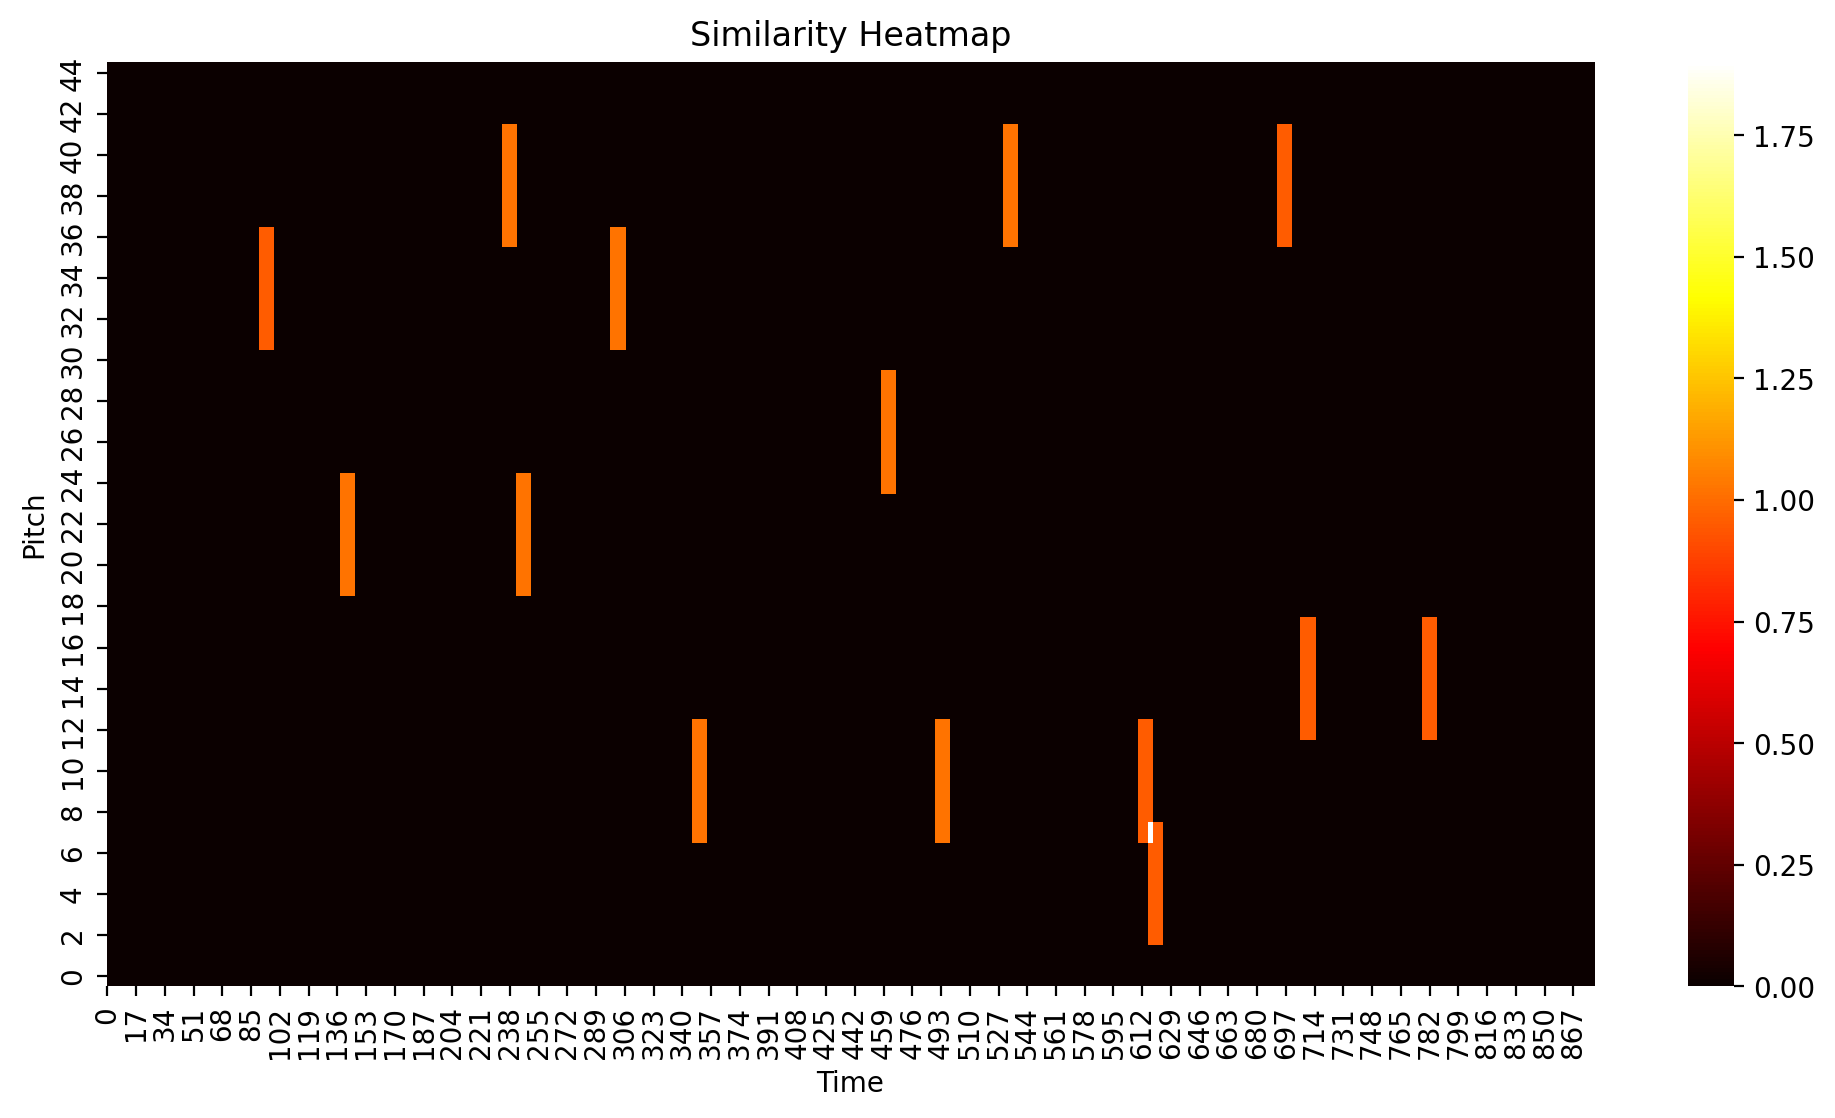

In [9]:
import numpy as np
from scipy.signal import correlate2d
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def compute_similarity(region, prototype):
    """
    Computes the normalized cross-correlation between a region and the prototype.
    """
    region = region.astype(float)
    prototype = prototype.astype(float)

    region_mean, prototype_mean = np.mean(region), np.mean(prototype)
    region_std, prototype_std = np.std(region), np.std(prototype)

    if region_std == 0 or prototype_std == 0:
        return 0.0

    region_normalized = (region - region_mean) / region_std
    prototype_normalized = (prototype - prototype_mean) / prototype_std

    correlation = np.sum(region_normalized * prototype_normalized)
    return correlation / (region.size - 1)

def resize_matrix(matrix, pitch_scale, time_scale):
    """
    Resizes the matrix according to pitch and time scales.
    """
    rows, cols = matrix.shape
    new_rows, new_cols = max(1, int(rows * pitch_scale)), max(1, int(cols * time_scale))
    resized_matrix = resize(matrix, (new_rows, new_cols), order=0, preserve_range=True, anti_aliasing=False)
    return (resized_matrix > 0.5).astype(int)

def multi_scale_template_matching(binary_matrix_auto, prototype_matrix, scale_factors, threshold=0.8):
    """
    Performs multi-scale template matching to find similar patterns in the large matrix.
    Prints the coordinates and similarity score of detected similarities.
    """
    auto_rows, auto_cols = binary_matrix_auto.shape
    heatmap = np.zeros((auto_rows, auto_cols))

    total_iterations = sum((auto_rows - int(prototype_matrix.shape[0] * p_scale) + 1) *
                           (auto_cols - int(prototype_matrix.shape[1] * t_scale) + 1)
                           for t_scale, p_scale in scale_factors)

    with tqdm(total=total_iterations, desc="Processing", unit="comparisons") as pbar:
        for time_scale, pitch_scale in scale_factors:
            scaled_prototype = resize_matrix(prototype_matrix, pitch_scale, time_scale)
            proto_rows, proto_cols = scaled_prototype.shape

            for i in range(auto_rows - proto_rows + 1):
                for j in range(auto_cols - proto_cols + 1):
                    region = binary_matrix_auto[i:i+proto_rows, j:j+proto_cols]
                    similarity = compute_similarity(region, scaled_prototype)
                    if similarity >= threshold:
                        heatmap[i:i+proto_rows, j:j+proto_cols] += similarity
                        print(f"Similarity detected at coordinates: (Pitch: {i}, Time: {j}), "
                              f"Scale (Pitch: {pitch_scale}, Time: {time_scale}), "
                              f"Similarity: {similarity:.4f}, Threshold: {threshold}")
                    pbar.update(1)

    return heatmap



# Define scale factors for pitch and time
pitch_scales = [1.0]
time_scales = [0.5, 1.0, 2.0]
scale_factors = [(t_scale, p_scale) for p_scale in pitch_scales for t_scale in time_scales]

# Assuming binary_matrix_auto and prototype_matrix are defined
heatmap = multi_scale_template_matching(binary_matrix_auto, prototype_matrix, scale_factors, threshold=0.95)

# Plotting the heatmap with the y-axis flipped
plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap, cmap='hot', cbar=True)
plt.title('Similarity Heatmap')
plt.xlabel('Time')
plt.ylabel('Pitch')

# Flip the y-axis
ax.invert_yaxis()

# Show the plot
plt.show()
